In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

import torch

from env import Environment
from models import Traider

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
@dataclass
class Config:

    observation_dim = 80

    num_hidden_layers = 3
    hidden_dim = 500
    dropout = 0.1
    use_softmax = True

    n_actions = 2

    levels = 40

    learning_rate = 0.0001

    epochs_limit = 50

    update_online_model_step = 5
    update_target_model_step = 250

    epsilon = 0.15

    transaction = 100.0

    batch_size = 64

    gamma = 0.9

    memory_limit = 10000

    train_data_path = 'train.data'

    test_data_path = 'test.data'

    device = 'cuda:0'

In [4]:
def test(environment, model, device, transaction):
    model.to(device)
    done = False
    state = environment.reset().astype(np.float32)
    total_reward = 0
    rewards = []
    
    while not done:
        state_tensor = torch.tensor(state).unsqueeze(0).to(device)
        action = np.argmax(model(state_tensor)[0].detach().cpu().numpy())
        state, reward, done = environment.step(action, transaction) 
        state = state.astype(np.float32)
        total_reward += reward
        rewards.append(total_reward)
    
    return rewards

In [5]:
def train(environment, test_environment, online_model, target_model, optimizer, loss_fn, cfg):
    online_model.to(cfg.device)
    target_model.to(cfg.device)
    
    for epoch in range(cfg.epochs_limit):
        
        print("epochs: " + str(epoch))
        
        actions_history     = []
        states_history      = []
        next_states_history = []
        rewards_history     = []
        
        done = False
        step = 0
        state = environment.reset()
        epoch_reward = 0
        
        while not done:
            
            step += 1
            
            if cfg.epsilon > np.random.random():
                action = np.random.choice(cfg.n_actions)
            else:
                
                state_tensor = torch.tensor(state).unsqueeze(0).float().to(cfg.device)
                action = torch.argmax(online_model(state_tensor)[0]).item()
            
            next_state, reward, done = environment.step(action, cfg.transaction) 
            
            epoch_reward += reward
            
            actions_history.append(action)
            states_history.append(state)
            next_states_history.append(next_state)
            rewards_history.append(reward)
            
            state = next_state
            
            if step % cfg.update_online_model_step == 0 and len(rewards_history) > cfg.batch_size:
                
                indices = np.random.choice(range(len(rewards_history)), size = cfg.batch_size)
                
                action_sample     = torch.tensor([actions_history     [i] for i in indices]) 
                state_sample      = torch.tensor([states_history      [i] for i in indices]).float().to(cfg.device) 
                next_state_sample = torch.tensor([next_states_history [i] for i in indices]).float().to(cfg.device)
                rewards_sample    = torch.tensor([rewards_history     [i] for i in indices]).float().to(cfg.device)
               
                with torch.no_grad():
                    out = target_model(next_state_sample)
                    future_rewards = torch.max(out, dim=1)[0] 
                
                updated_q_values = rewards_sample + cfg.gamma * future_rewards

                mask = torch.nn.functional.one_hot(action_sample, cfg.n_actions).to(cfg.device)

                q_values = online_model(state_sample)
                q_action = torch.sum(q_values * mask, dim=1)
                optimizer.zero_grad()

                loss = loss_fn(updated_q_values, q_action)
                loss.backward()
                optimizer.step()
                
            # print(epoch_reward)
        
            if step % cfg.update_target_model_step == 0:
                
                target_model.load_state_dict(online_model.state_dict())
            
            if len(rewards_history) > cfg.memory_limit:
                del actions_history     [:1]
                del states_history      [:1]
                del next_states_history [:1]
                del rewards_history     [:1]
        
        print("train reward: %.2f" % epoch_reward)
        test_rewards = test(test_environment, target_model, cfg.device, cfg.transaction)
        last_test_reward = (test_rewards[-1] - test_rewards[-365//2])
        print("test reward for last half a year: %.2f" % last_test_reward)
        plt.plot(test_rewards)
        plt.title("Test reward")
        plt.show()
        # if test_reward > 100:
        #     break

In [6]:
cfg = Config()

online_model = Traider(in_dim=cfg.observation_dim, 
                       hidden_dim=cfg.hidden_dim,
                       out_dim=cfg.n_actions, 
                       num_hidden_layers=cfg.num_hidden_layers,
                       dropout = cfg.dropout,
                       use_softmax = cfg.use_softmax)
target_model = Traider(in_dim=cfg.observation_dim, 
                       hidden_dim=cfg.hidden_dim,
                       out_dim=cfg.n_actions, 
                       num_hidden_layers=cfg.num_hidden_layers,
                       dropout = cfg.dropout,
                       use_softmax = cfg.use_softmax)

environment_train = Environment(cfg.train_data_path, cfg.levels, cfg.observation_dim)

environment_test = Environment(cfg.test_data_path, 1, cfg.observation_dim)

loss_fn = torch.nn.HuberLoss()

optimizer = torch.optim.Adam(online_model.parameters(), lr=cfg.learning_rate)

epochs: 0


C:\Users\makov\AppData\Local\Temp\ipykernel_4976\4128242797.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state_sample      = torch.tensor([states_history      [i] for i in indices]).float().to(cfg.device)


train reward: -6765.26
test reward for last half a year: -3.90


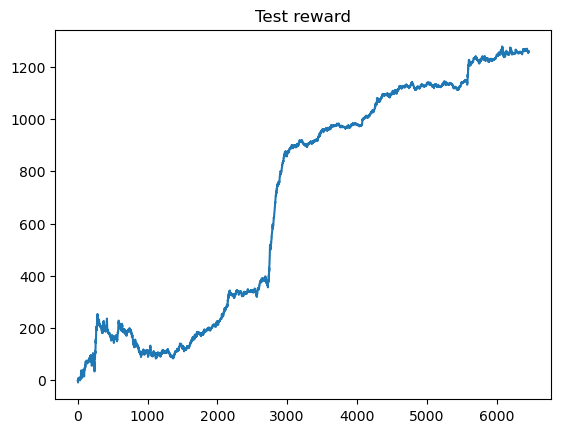

epochs: 1
train reward: 12343.66
test reward for last half a year: 4.38


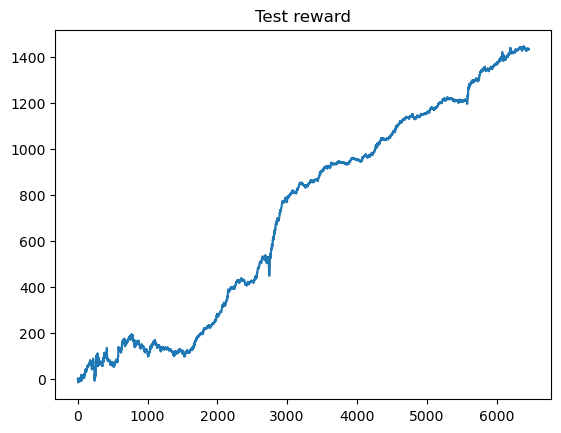

epochs: 2
train reward: 21210.81
test reward for last half a year: 1.92


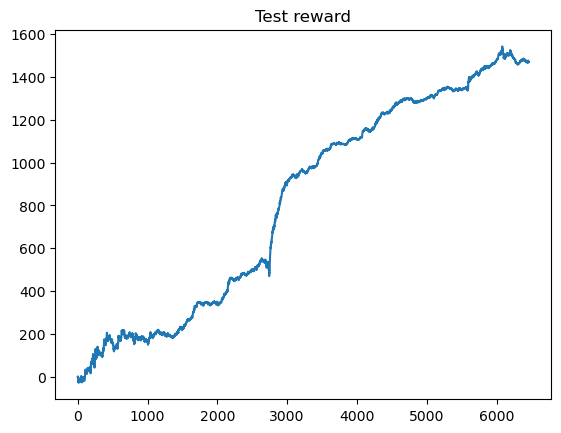

epochs: 3
train reward: 27056.24
test reward for last half a year: -33.46


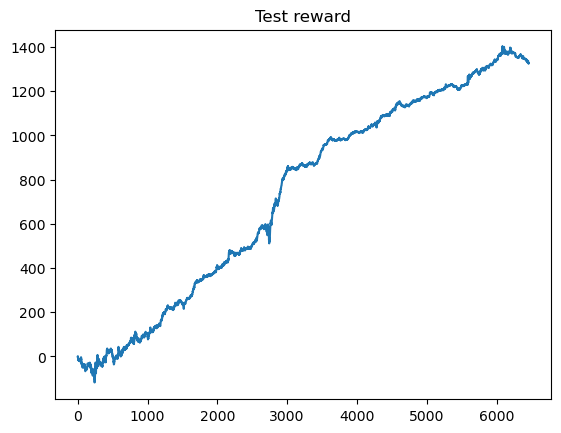

epochs: 4
train reward: 54334.42
test reward for last half a year: -10.46


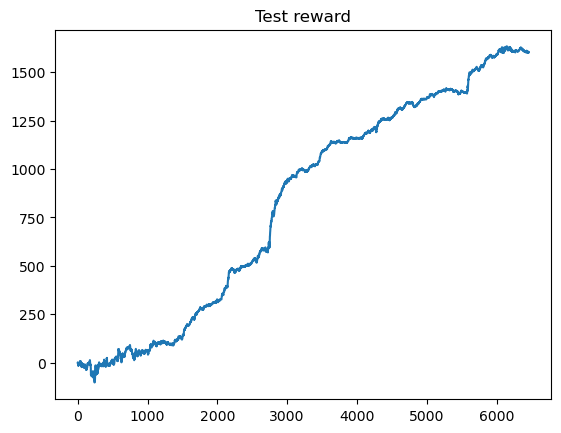

epochs: 5
train reward: 60179.14
test reward for last half a year: 7.46


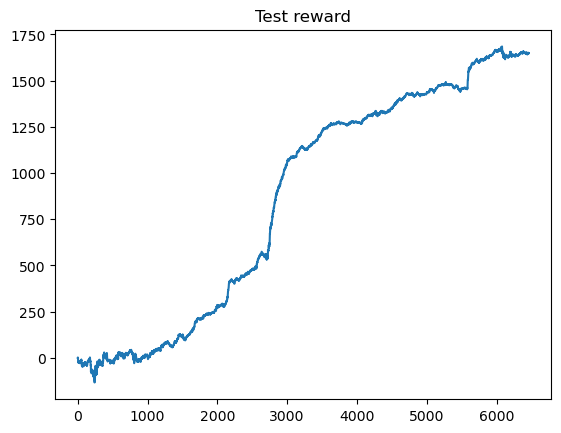

epochs: 6
train reward: 63236.70
test reward for last half a year: -20.58


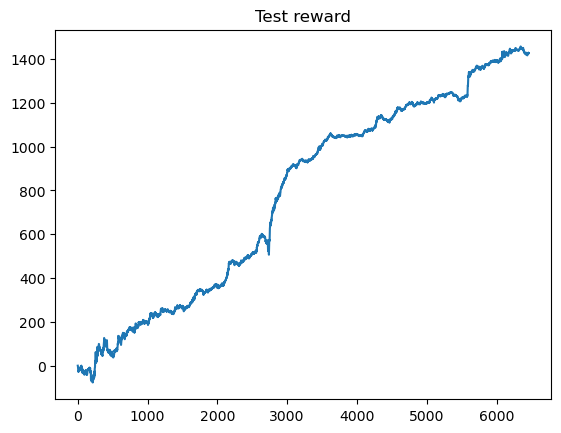

epochs: 7
train reward: 43456.54
test reward for last half a year: -1.87


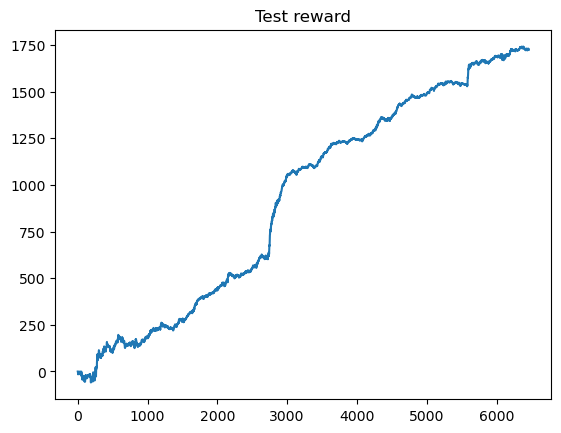

epochs: 8
train reward: 46578.09
test reward for last half a year: -26.41


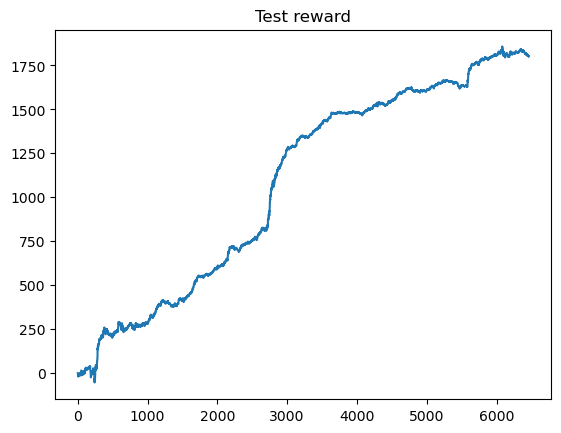

epochs: 9
train reward: 47387.67
test reward for last half a year: -29.82


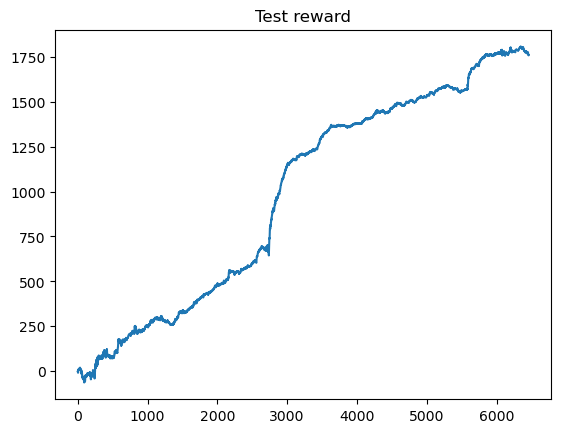

epochs: 10
train reward: 70364.11
test reward for last half a year: -22.55


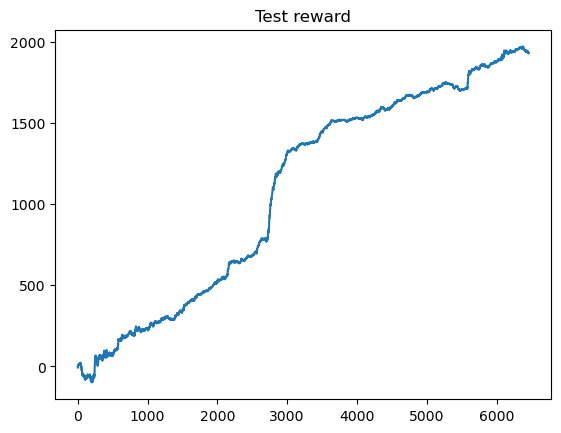

epochs: 11
train reward: 51849.26
test reward for last half a year: -28.96


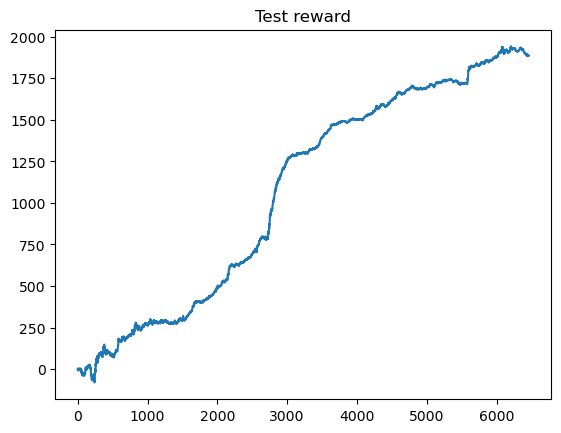

epochs: 12
train reward: 75870.83
test reward for last half a year: -14.93


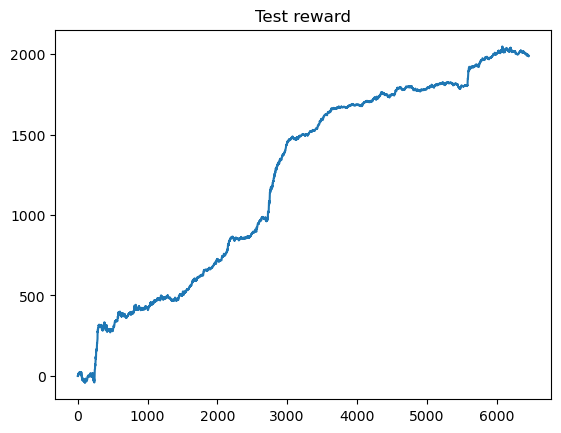

epochs: 13
train reward: 80081.49
test reward for last half a year: 7.03


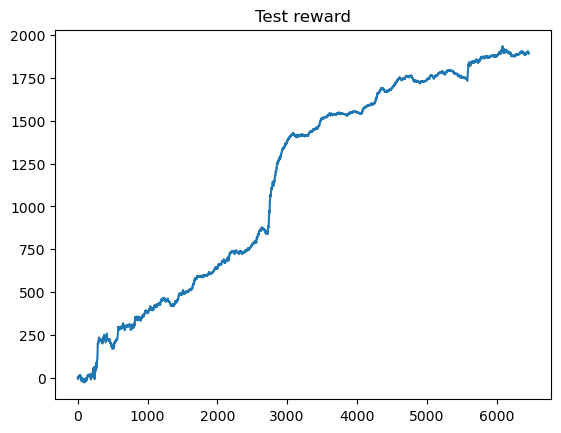

epochs: 14
train reward: 79329.99
test reward for last half a year: -38.77


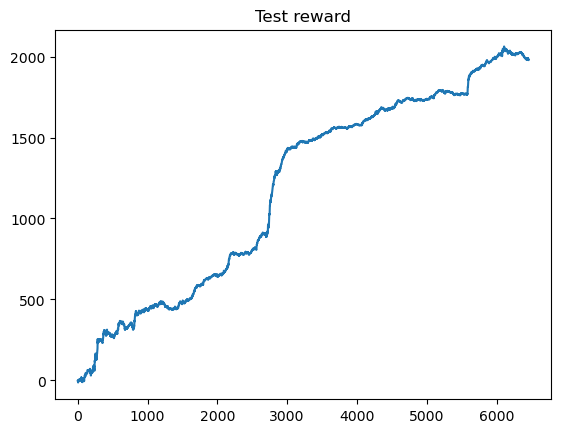

epochs: 15
train reward: 58650.63
test reward for last half a year: -6.92


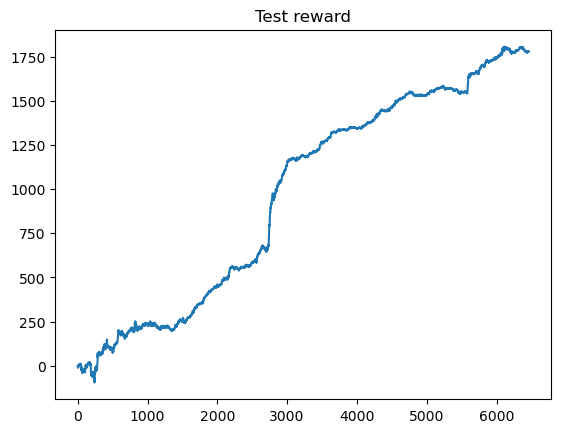

epochs: 16
train reward: 82202.56
test reward for last half a year: -16.89


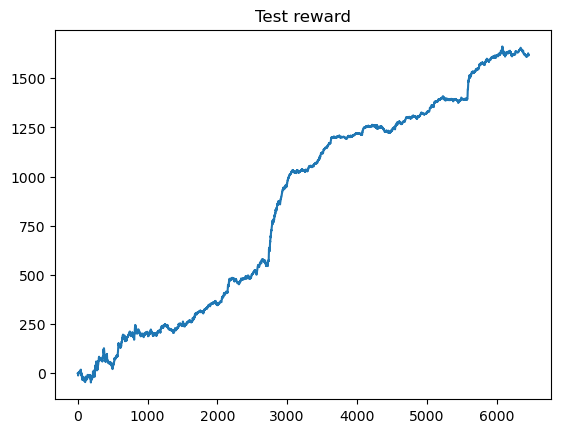

epochs: 17
train reward: 82811.84
test reward for last half a year: -33.66


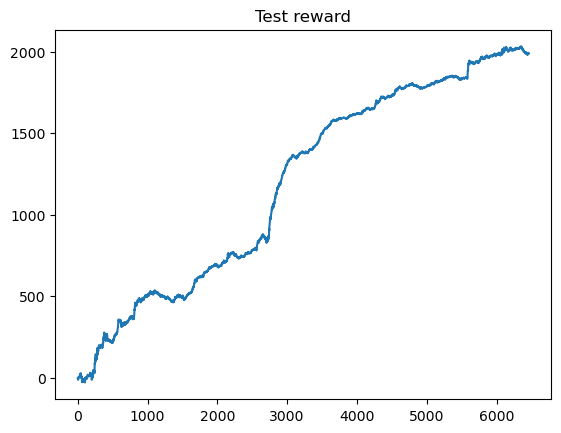

epochs: 18
train reward: 84102.71
test reward for last half a year: -31.71


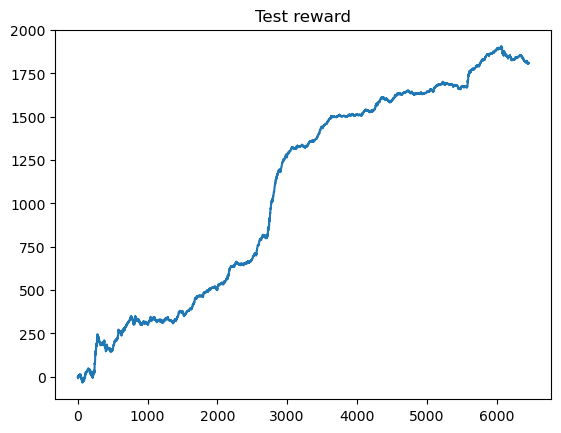

epochs: 19
train reward: 86324.89
test reward for last half a year: -8.02


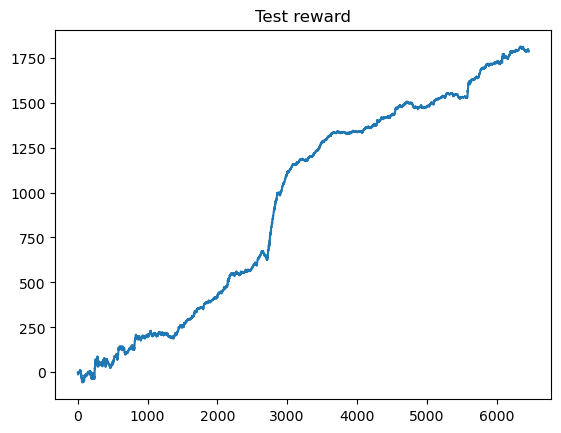

epochs: 20
train reward: 66286.68
test reward for last half a year: -19.86


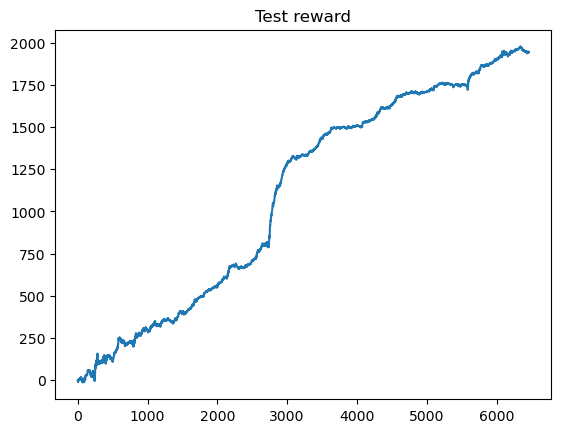

epochs: 21
train reward: 88352.29
test reward for last half a year: -18.27


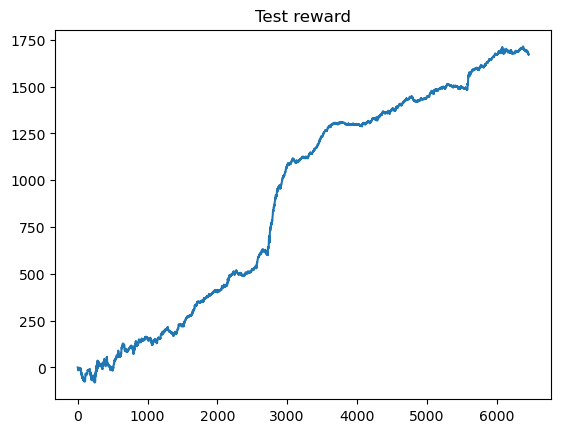

epochs: 22
train reward: 89139.28
test reward for last half a year: -17.48


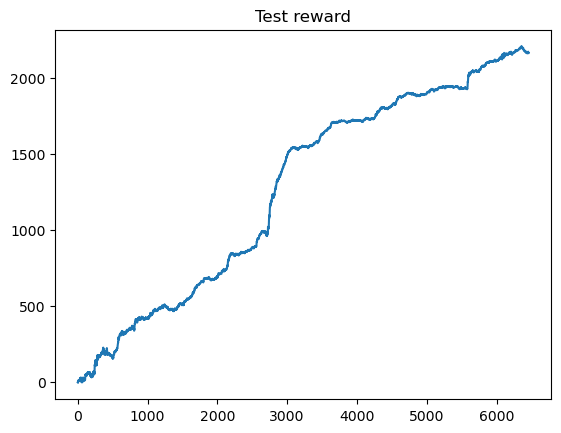

epochs: 23
train reward: 68123.54
test reward for last half a year: -14.50


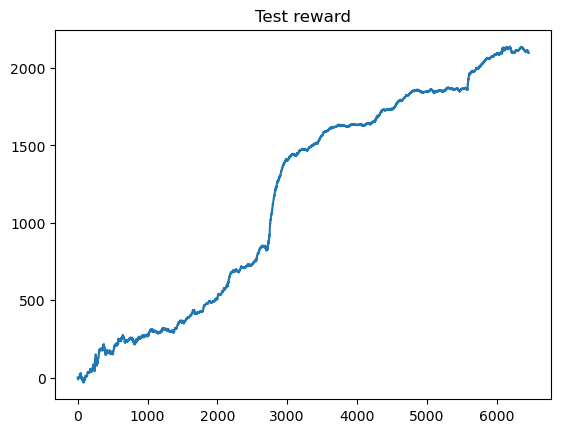

epochs: 24
train reward: 68655.01
test reward for last half a year: -2.75


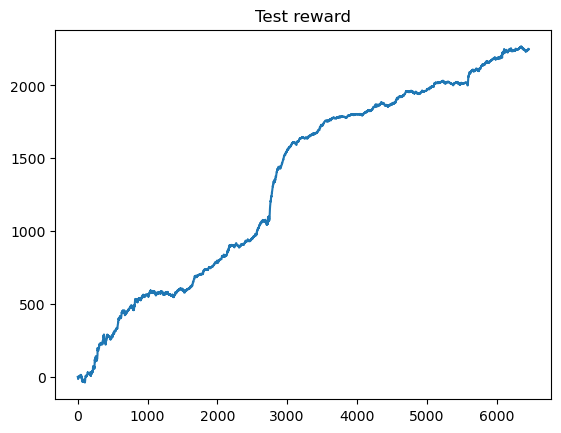

epochs: 25
train reward: 93990.58
test reward for last half a year: -10.45


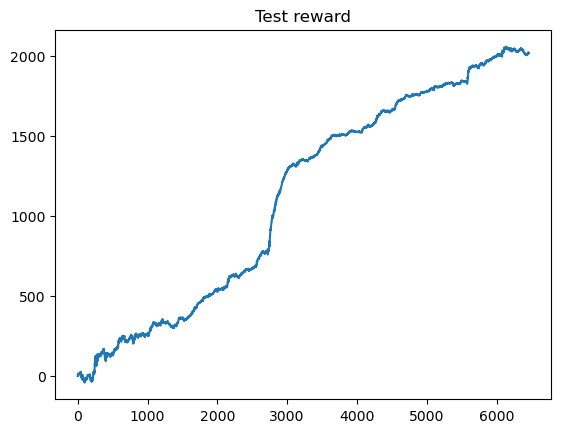

epochs: 26
train reward: 94306.92
test reward for last half a year: -13.87


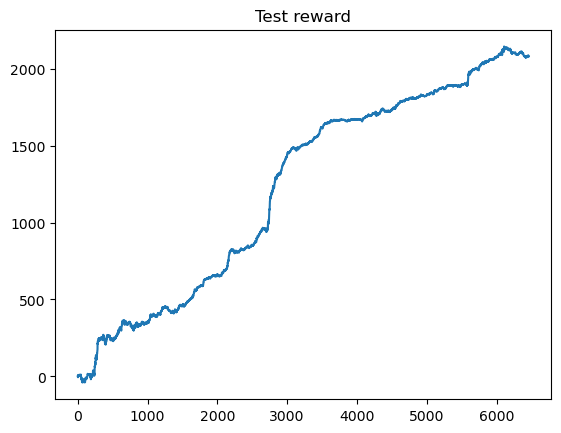

epochs: 27
train reward: 94830.12
test reward for last half a year: -30.45


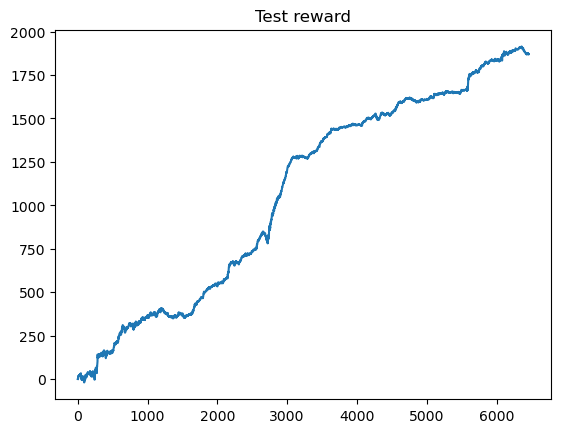

epochs: 28
train reward: 94495.18
test reward for last half a year: -9.54


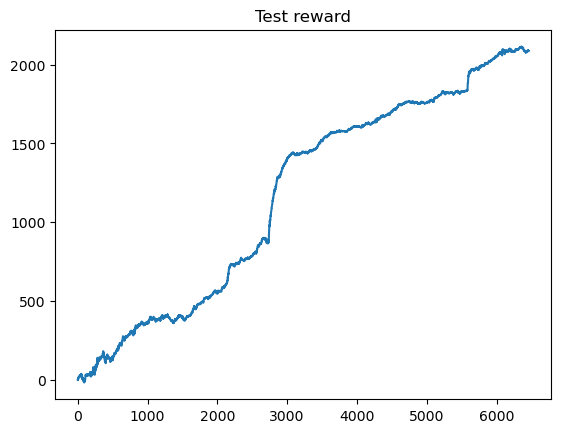

epochs: 29
train reward: 94612.08
test reward for last half a year: -1.75


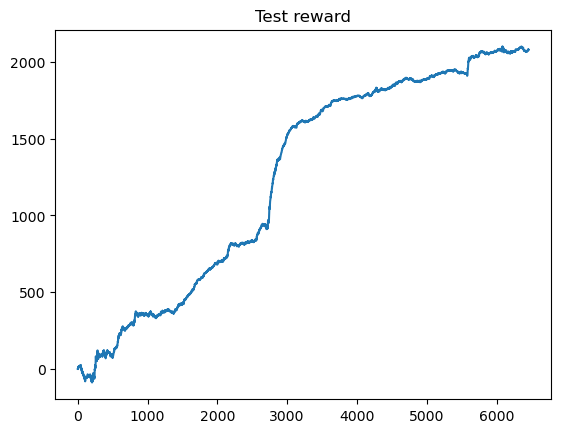

epochs: 30
train reward: 94266.31
test reward for last half a year: 11.52


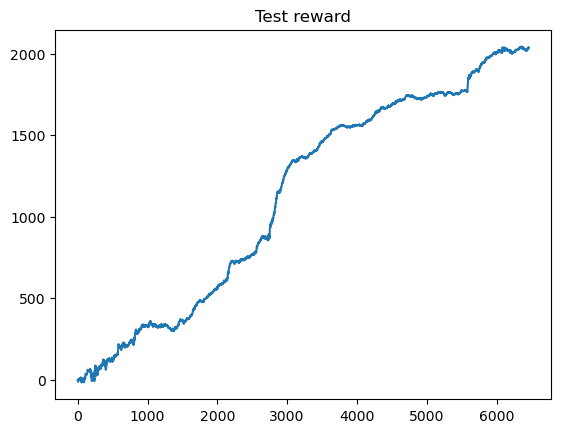

epochs: 31
train reward: 97446.49
test reward for last half a year: 0.84


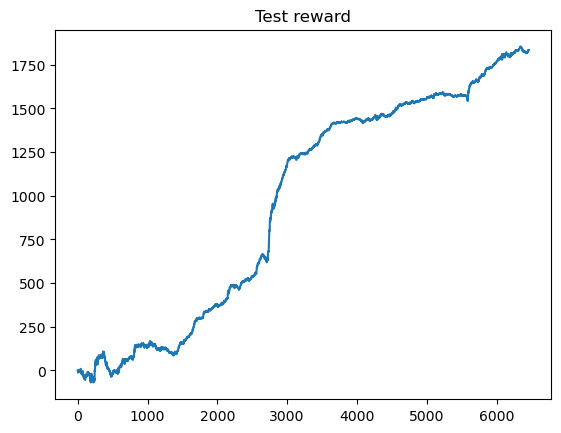

epochs: 32
train reward: 100075.59
test reward for last half a year: 9.51


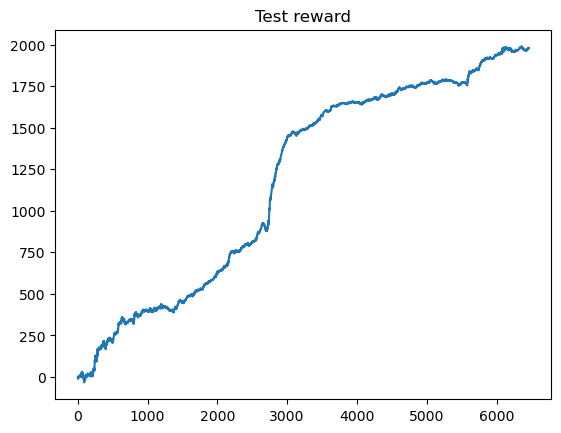

epochs: 33
train reward: 99462.32
test reward for last half a year: -3.40


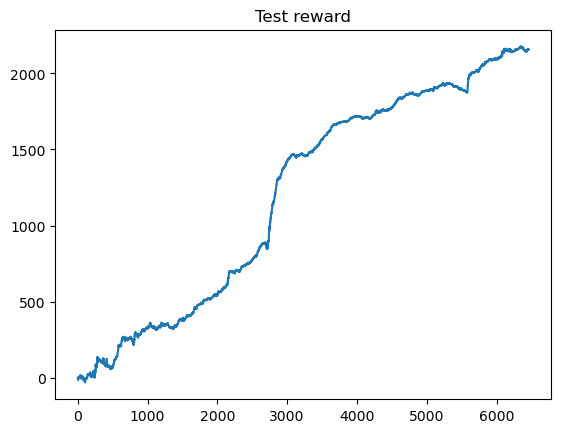

epochs: 34
train reward: 97700.41
test reward for last half a year: -6.55


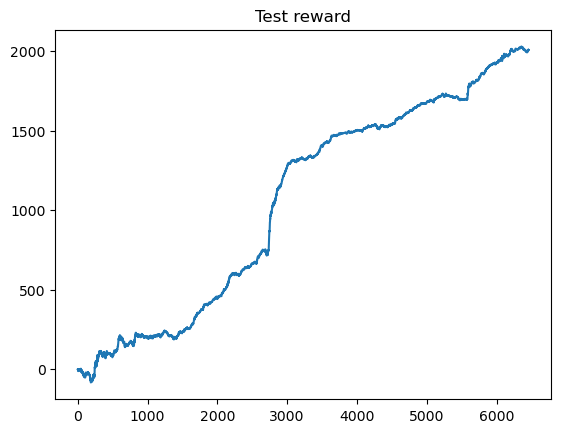

epochs: 35
train reward: 101353.29
test reward for last half a year: -24.19


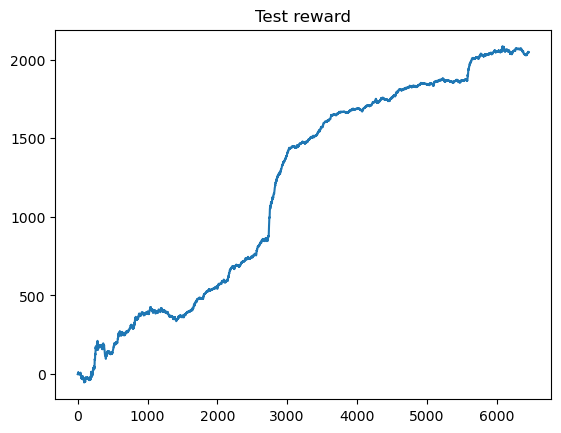

epochs: 36
train reward: 100491.78
test reward for last half a year: -4.94


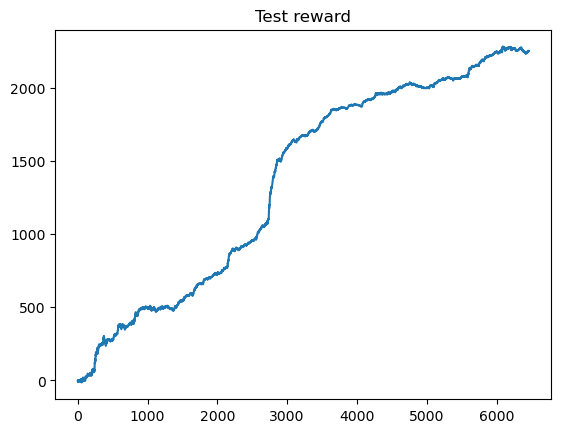

epochs: 37
train reward: 100793.78
test reward for last half a year: -5.45


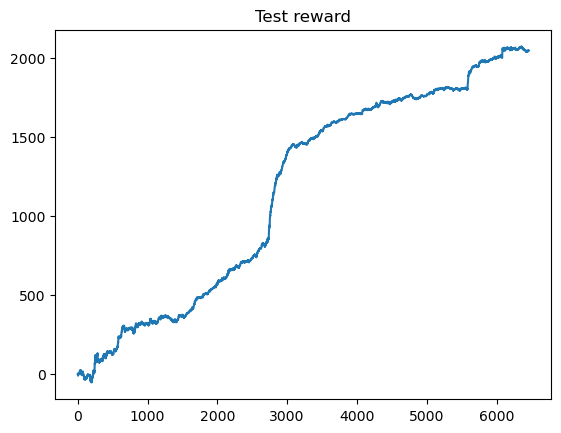

epochs: 38
train reward: 102592.16
test reward for last half a year: 5.68


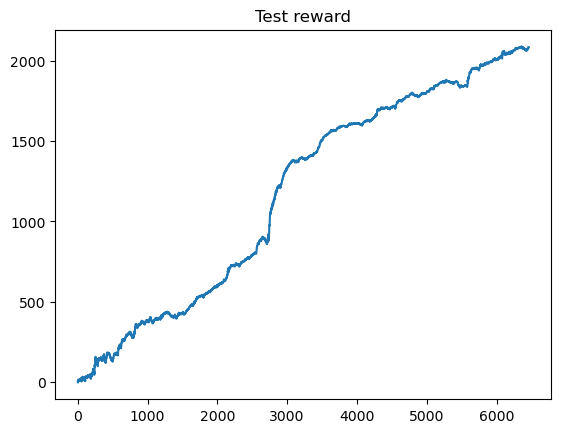

epochs: 39
train reward: 79889.12
test reward for last half a year: -7.11


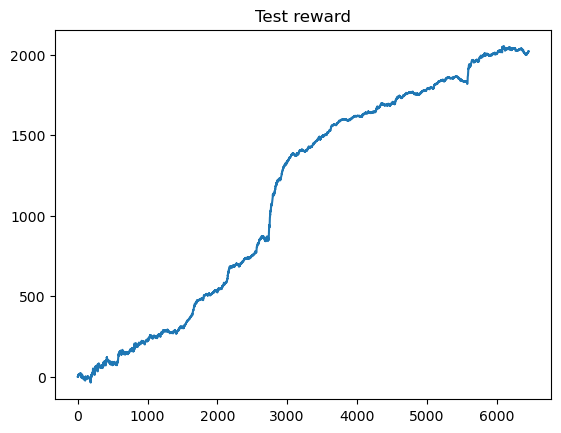

epochs: 40
train reward: 103354.78
test reward for last half a year: -16.89


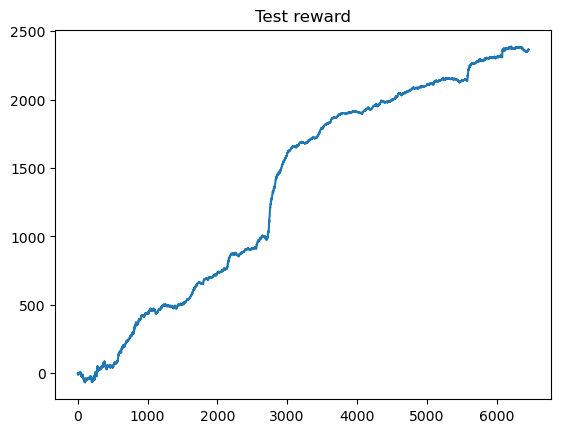

epochs: 41
train reward: 101913.33
test reward for last half a year: -10.10


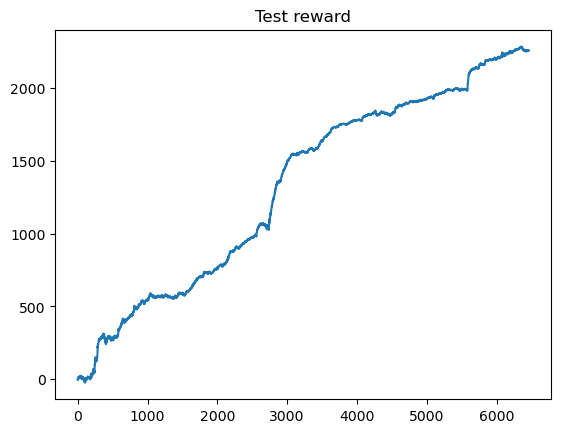

epochs: 42
train reward: 105322.11
test reward for last half a year: 4.89


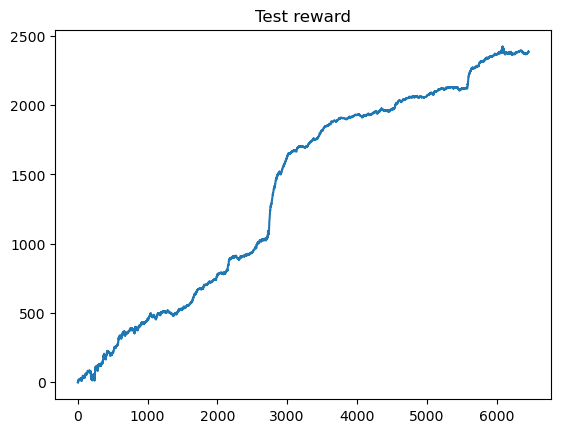

epochs: 43
train reward: 104503.24
test reward for last half a year: 2.71


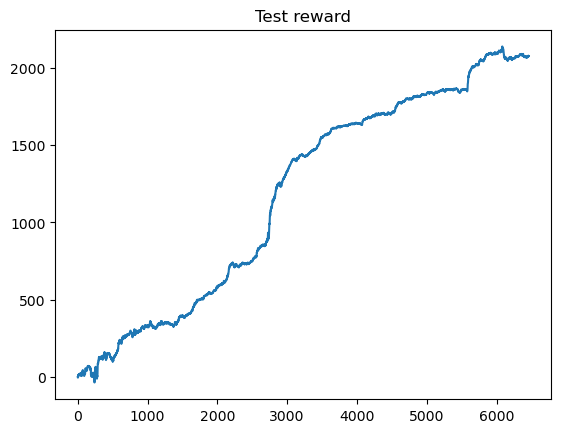

epochs: 44
train reward: 103272.75
test reward for last half a year: 0.51


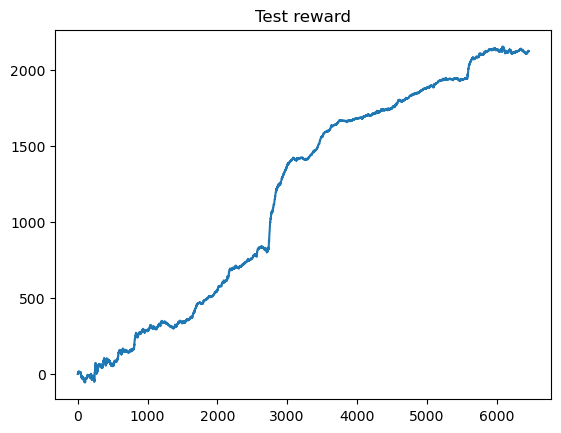

epochs: 45
train reward: 104069.97
test reward for last half a year: -10.58


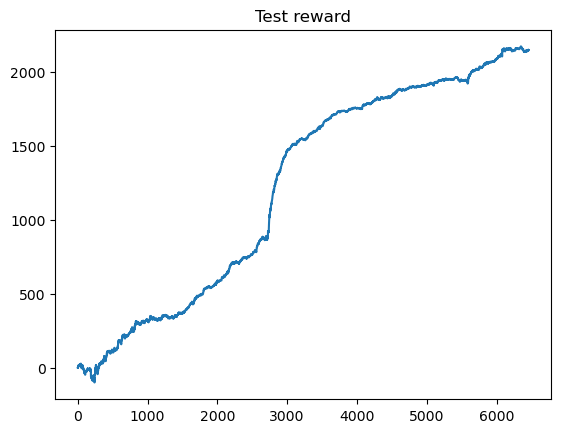

epochs: 46
train reward: 105894.51
test reward for last half a year: 11.38


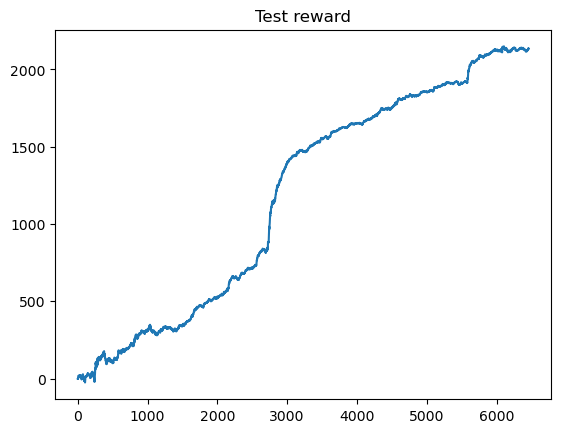

epochs: 47
train reward: 106920.17
test reward for last half a year: 17.65


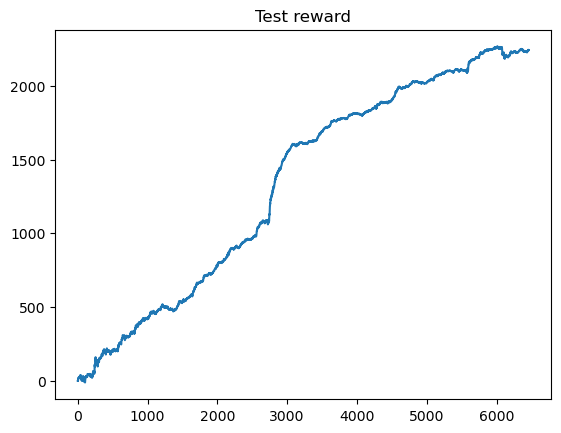

epochs: 48
train reward: 107334.25
test reward for last half a year: 27.08


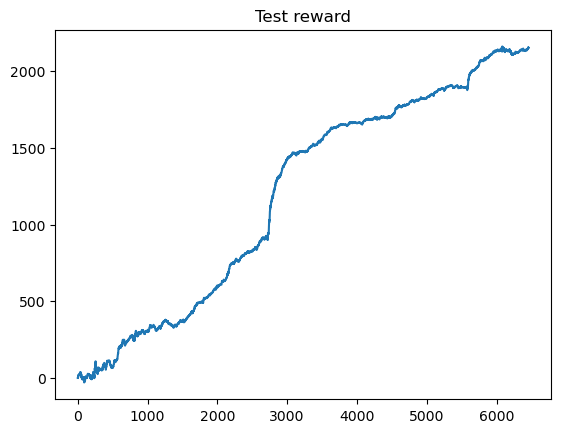

epochs: 49
train reward: 107525.19
test reward for last half a year: 23.82


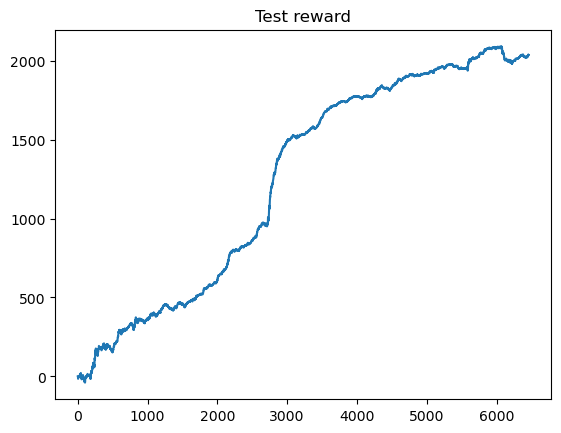

In [7]:
train(environment_train, environment_test, online_model, target_model, optimizer, loss_fn, cfg)

In [8]:
len(np.where(np.array(actions) ==0)[0]), len(np.where(np.array(actions) ==1)[0])

NameError: name 'actions' is not defined